# Classification workflow:

1) Load and normalize (by Standard and MinMax sclaer) all protocol data

2) Segregate spectra and extract features: segment duration=5.12sec, data length after flattening=16070

3) Train-validation-test split

4) PCA: figure out the number of component to keep by using train and validation set

5) PCA transformation

6) Logistic Regression Classification: do grid-search to optimize the classifier parameter

7) SVM Classification: do grid-search to optimize the classifier parameter

8) LOSO using optimized pararmeters from step 4, 6, 7.

In [57]:
import numpy as np
import DataProcess as DP
import FeatureCalculate as FC
import DataProcessForPCA as DPpca
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC

## 1) Load and Normalize Data:

In [2]:
# Use StandardScaler:
specchunks=[]
for i in DP.protocol_list:
    X_std, specchunk = DPpca.preprocess(i, 1000, rescale=True, scaler='standard')
    specchunks.append(np.array(specchunk))

# Use MinMaxScaler:
specchunks2=[]
for i in DP.protocol_list:
    X_std, specchunk2 = DPpca.preprocess(i, 1000, rescale=True, scaler='minmax')
    specchunks2.append(np.array(specchunk2))

## 2) Data segmentation + Feature extraction + Flattening:

In [3]:
chunks=[]
for i in range(len(specchunks)):
    chunks.append(DPpca.segmentation(specchunks[i],T=512,stride=512))

chunks2=[]
for i in range(len(specchunks2)):
    chunks2.append(DPpca.segmentation(specchunks2[i],T=512,stride=512))

In [9]:
for i in range(len(chunks)):
    print(chunks[i].shape)

(426, 16070)
(453, 16070)
(292, 16070)
(399, 16070)
(472, 16070)
(432, 16070)
(398, 16070)
(450, 16070)
(8, 16070)


## 3) Train-validation-test split (0.7: 0.12: 0.18)

In [5]:
# Stack data from different subjects into one chunk:
data = np.vstack(chunks)
data2 = np.vstack(chunks2)

#shuffle data
np.random.shuffle(data)
np.random.shuffle(data2)

X = data[:,:-1]
y = data[:,-1]
X2 = data2[:,:-1]
y2 = data2[:,-1]

In [6]:
# Calculate class_weight of activities:
actID, counts = np.unique(y, return_counts=True)
weight = counts/np.sum(counts)
act_weight = dict(zip(actID, weight))
act_weight

{1.0: 0.10270270270270271,
 2.0: 0.097897897897897893,
 3.0: 0.1012012012012012,
 4.0: 0.12912912912912913,
 5.0: 0.049849849849849852,
 6.0: 0.087687687687687685,
 7.0: 0.1012012012012012,
 12.0: 0.047447447447447451,
 13.0: 0.039339339339339342,
 16.0: 0.092192192192192199,
 17.0: 0.12912912912912913,
 24.0: 0.022222222222222223}

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=42)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.18, random_state=42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.12, random_state=42)

## 4) PCA: find out ideal n_components by using train and validation set

**Eigen-values:**

In [10]:
#Perform eigendecomposition on covariance matrix
cov_mat = np.cov(X_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

cov_mat2 = np.cov(X2_train.T)
eig_vals2, eig_vecs2 = np.linalg.eig(cov_mat2)

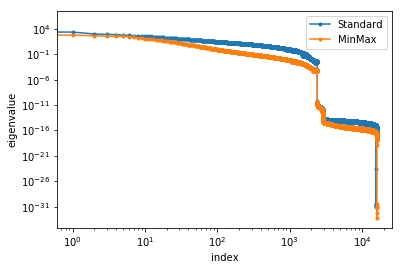

In [11]:
n = len(np.abs(eig_vals))
plt.plot(np.linspace(0, n-1, n), np.abs(eig_vals), label='Standard', marker='o', ms=3)
plt.plot(np.linspace(0, n-1, n), np.abs(eig_vals2), label='MinMax', marker='o', ms=3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('index')
plt.ylabel('eigenvalue')
plt.legend();

### Scree plot:

In [35]:
pca = PCA().fit(X_train)
pca2 = PCA().fit(X2_train)

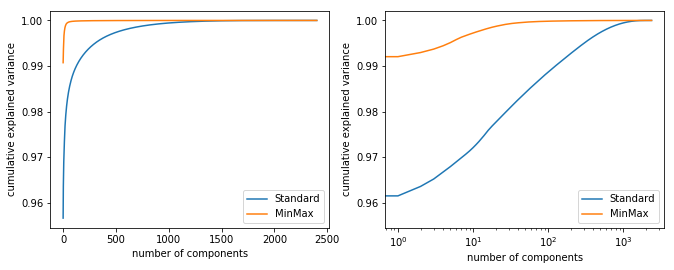

In [14]:
plt.figure(figsize=[11, 4])
plt.subplot(121)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Standard')
plt.plot(np.cumsum(pca2.explained_variance_ratio_), label='MinMax')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend()

plt.subplot(122)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Standard')
plt.plot(np.cumsum(pca2.explained_variance_ratio_), label='MinMax')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xscale('log')
plt.legend();

### Visualize acitivities in eigen-space:

In [54]:
pca = PCA(n_components=3)
pca2 = PCA(n_components=3)
X_tr = pca.fit_transform(X_train)
X2_tr = pca2.fit_transform(X2_train)

In [102]:
trdata=np.hstack((np.reshape(y_train, (2402, 1)), X_tr))
trdict = {}
for a in np.unique(y_train):
    trdict[a] = trdata[np.where(trdata[:, 0]==a)[0]][:, 1:]

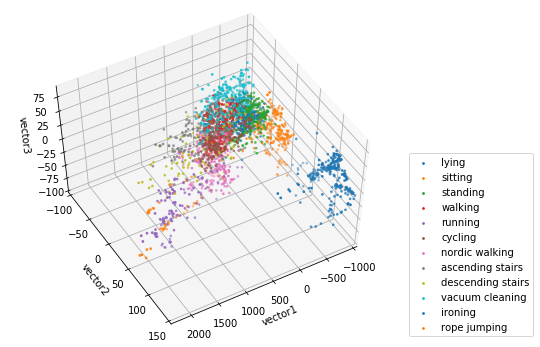

In [138]:
fig = plt.figure(figsize=[7, 6])
ax=fig.add_subplot(111, projection='3d')
for a in np.unique(y_train):
    ax.scatter(trdict[a][:,0], trdict[a][:,1], trdict[a][:,2], s=3, label=DP.activity_dict[a])

ax.set_xlim(-1000, 2300)
ax.set_ylim(-100, 150)
ax.set_zlim(-100, 90)
ax.set_xlabel('vector1')
ax.set_ylabel('vector2')
ax.set_zlabel('vector3')
ax.view_init(elev=55, azim=60)
ax.legend(loc=(1.02,0));

In [117]:
# Interactive plot
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace = []
for a in np.unique(y_train):
    trace.append(go.Scatter3d(x=trdict[a][:,0], y=trdict[a][:,1], z=trdict[a][:,2], 
                              mode='markers', marker=dict(size=3)))
    
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
py.iplot(go.Figure(data=trace, layout=layout))

### Find optimal n_components:

In [36]:
train_scores = []
train_scores2 = []
val_scores = []
val_scores2 = []
components = [2,4,6,8,10,15,20,25,40,70,100,150,200,300,400,500,600,800,1000]
for i in components:
    pca = PCA(n_components=i)
    pca2 = PCA(n_components=i)
    X_tr = pca.fit_transform(X_train)
    X2_tr = pca2.fit_transform(X2_train)
    X_v = pca.transform(X_val)
    X2_v = pca2.transform(X2_val)
    
    # Use parameters from Kathryn's test:
    cls = LogisticRegression(penalty='l1', C=30, class_weight=act_weight)
    cls2 = LogisticRegression(penalty='l1', C=30, class_weight=act_weight)
    cls.fit(X_tr,y_train)
    cls2.fit(X2_tr,y2_train)
    train_scores.append(cls.score(X_tr,y_train))
    train_scores2.append(cls2.score(X2_tr,y2_train))
    val_scores.append(cls.score(X_v,y_val))
    val_scores2.append(cls2.score(X2_v,y2_val))

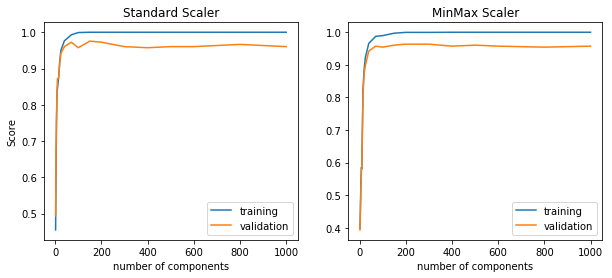

In [37]:
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.plot(components, train_scores, label='training')
plt.plot(components, val_scores, label='validation')
plt.xlabel('number of components')
plt.ylabel('Score')
plt.title('Standard Scaler')
plt.legend()

plt.subplot(122)
plt.plot(components, train_scores2, label='training')
plt.plot(components, val_scores2, label='validation')
plt.xlabel('number of components')
plt.title('MinMax Scaler')
plt.legend()
plt.show()

In [38]:
print('Optimal n_components & validation score:')
n1 = components[np.argmax(val_scores)]
n2 = components[np.argmax(val_scores2)]
print('Standard Scaler: {},\tScore = {}'.format(components[np.argmax(val_scores)], val_scores[np.argmax(val_scores)]))
print('MinMax Scaler:{},\tScore = {}'.format(components[np.argmax(val_scores2)], val_scores2[np.argmax(val_scores2)]))

Optimal n_components & validation score:
Standard Scaler: 150,	Score = 0.975609756097561
MinMax Scaler:200,	Score = 0.9634146341463414


**MinMax scaler needs more components than standard scaler.**

## 5) PCA Transformation: 

In [39]:
pca = PCA(n_components=n1)
X_train_pca = pca.fit_transform(np.vstack((X_train, X_val)))
X_test_pca = pca.transform(X_test)
y_train_pca = np.append(y_train, y_val)

pca2 = PCA(n_components=n2)
X2_train_pca = pca2.fit_transform(np.vstack((X2_train, X2_val)))
X2_test_pca = pca2.transform(X2_test)
y2_train_pca = np.append(y2_train, y2_val)

## 6) Logistic Regression:

**Quick peek: Test score of using logistic regression is 0.9517 (Standard) and 0.9783 (MinMax).**

### Grid Search Parameters:
**Standard Scaler:**

In [40]:
# Set up the hyperparameter parameterspace
logreg_param_grid = {'C': [0.1, 0.3, 1, 3, 10], 
                     'penalty' : ["l1", "l2"],
                     'class_weight': ["balanced", act_weight, None]}

In [41]:
logreg = LogisticRegression()
logreg_gs = GridSearchCV(logreg, logreg_param_grid, cv=5)
%time logreg_gs.fit(X_train_pca, y_train_pca)

Wall time: 14min 43s


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.3, 1, 3, 10], 'penalty': ['l1', 'l2'], 'class_weight': ['balanced', {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
print("Optimal Parameters: {}".format(logreg_gs.best_params_))
print("Best score: {}".format(logreg_gs.best_score_))

Optimal Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}
Best score: 0.967032967032967


In [43]:
y_pred_log = logreg_gs.predict(X_test_pca)
print('test score=', logreg_gs.score(X_test_pca, y_test))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

test score= 0.973333333333
[[57  1  0  0  0  0  0  0  0  0  0  0]
 [ 1 56  1  0  0  0  0  0  0  0  0  0]
 [ 0  2 58  0  0  0  0  0  0  0  2  0]
 [ 0  0  0 84  0  0  1  0  1  0  0  0]
 [ 0  0  0  0 29  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 40  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 64  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 24  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 52  4  0]
 [ 0  0  0  0  0  0  0  0  0  1 80  0]
 [ 0  0  0  0  1  0  0  0  0  0  0 16]]
             precision    recall  f1-score   support

        1.0       0.98      0.98      0.98        58
        2.0       0.95      0.97      0.96        58
        3.0       0.98      0.94      0.96        62
        4.0       1.00      0.98      0.99        86
        5.0       0.97      1.00      0.98        29
        6.0       1.00      1.00      1.00        40
        7.0       0.98      0.98      0.98        65
       12.0       0.96      1.00      0.98        24
       13.0       0.96    

**MinMax Scaler:**

In [44]:
logreg = LogisticRegression()
logreg_gs2 = GridSearchCV(logreg, logreg_param_grid, cv=5)
%time logreg_gs2.fit(X2_train_pca, y2_train_pca)

Wall time: 17min 10s


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.3, 1, 3, 10], 'penalty': ['l1', 'l2'], 'class_weight': ['balanced', {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
print("Optimal Parameters: {}".format(logreg_gs2.best_params_))
print("Best score: {}".format(logreg_gs2.best_score_))

Optimal Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
Best score: 0.9666666666666667


In [46]:
y2_pred_log = logreg_gs2.predict(X2_test_pca)
print('test score=', logreg_gs2.score(X2_test_pca, y2_test))
print(confusion_matrix(y2_test, y2_pred_log))
print(classification_report(y2_test, y2_pred_log))

test score= 0.978333333333
[[62  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 48  3  0  0  0  0  0  0  1  0  0]
 [ 0  1 46  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 77  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 33  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 52  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 23  0  0  0]
 [ 0  0  0  0  1  0  0  1  0 64  2  0]
 [ 0  1  0  0  0  0  0  0  0  0 84  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 16]]
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        62
        2.0       0.96      0.92      0.94        52
        3.0       0.92      0.98      0.95        47
        4.0       0.99      1.00      0.99        77
        5.0       0.94      0.97      0.96        34
        6.0       1.00      1.00      1.00        52
        7.0       1.00      1.00      1.00        52
       12.0       0.97      0.97      0.97        31
       13.0       1.00    

## 7) SVM:
**Quick peek: Test score of using SVM is 0.9817 (Standard) and 0.9867 (MinMax).**

### Grid Search Parameters:
**Standard Scaler:**

In [47]:
# Set up the hyperparameter parameterspace
svm_param_grid = {'C': [0.05, 0.1, 0.3, 0.5, 1], 
                  'kernel' : ["linear", "poly"],
                  'tol': [1, 5e-1, 3e-1, 1e-1, 3e-2, 1e-2],
                  'class_weight': ["balanced", act_weight, None]}

In [48]:
svm = SVC()
svm_gs = GridSearchCV(svm, svm_param_grid, cv=5)
%time svm_gs.fit(X_train_pca, y_train_pca)

Wall time: 7min 17s


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.05, 0.1, 0.3, 0.5, 1], 'kernel': ['linear', 'poly'], 'tol': [1, 0.5, 0.3, 0.1, 0.03, 0.01], 'class_weight': ['balanced', {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
print("Optimal Parameters: {}".format(svm_gs.best_params_))
print("Best score: {}".format(svm_gs.best_score_))

Optimal Parameters: {'C': 0.05, 'class_weight': 'balanced', 'kernel': 'linear', 'tol': 0.01}
Best score: 0.9838827838827838


In [50]:
y_pred_svm = svm_gs.predict(X_test_pca)
print('test score=', svm_gs.score(X_test_pca, y_test))
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

test score= 0.978333333333
[[58  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 57  1  0  0  0  0  0  0  0  0  0]
 [ 0  0 60  0  0  0  0  0  0  0  2  0]
 [ 0  0  0 85  0  0  0  0  1  0  0  0]
 [ 0  0  0  0 29  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 40  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 65  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 22  0  1  0  0]
 [ 0  0  0  0  0  1  0  0 23  0  0  0]
 [ 0  1  0  0  0  0  0  0  0 52  3  0]
 [ 0  0  0  0  0  0  0  0  0  1 80  0]
 [ 0  0  0  0  1  0  0  0  0  0  0 16]]
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        58
        2.0       0.98      0.98      0.98        58
        3.0       0.98      0.97      0.98        62
        4.0       0.99      0.99      0.99        86
        5.0       0.97      1.00      0.98        29
        6.0       0.98      1.00      0.99        40
        7.0       1.00      1.00      1.00        65
       12.0       1.00      0.92      0.96        24
       13.0       0.96    

**MinMax Scaler:**

In [51]:
svm = SVC()
svm_gs2 = GridSearchCV(svm, svm_param_grid, cv=5)
%time svm_gs2.fit(X2_train_pca, y2_train_pca)

Wall time: 11min 7s


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.05, 0.1, 0.3, 0.5, 1], 'kernel': ['linear', 'poly'], 'tol': [1, 0.5, 0.3, 0.1, 0.03, 0.01], 'class_weight': ['balanced', {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [52]:
print("Optimal Parameters: {}".format(svm_gs2.best_params_))
print("Best score: {}".format(svm_gs2.best_score_))

Optimal Parameters: {'C': 0.05, 'class_weight': {1.0: 0.10270270270270271, 2.0: 0.097897897897897893, 3.0: 0.1012012012012012, 4.0: 0.12912912912912913, 5.0: 0.049849849849849852, 6.0: 0.087687687687687685, 7.0: 0.1012012012012012, 12.0: 0.047447447447447451, 13.0: 0.039339339339339342, 16.0: 0.092192192192192199, 17.0: 0.12912912912912913, 24.0: 0.022222222222222223}, 'kernel': 'linear', 'tol': 0.01}
Best score: 0.9765567765567765


In [53]:
y2_pred_svm = svm_gs2.predict(X2_test_pca)
print('test score=', svm_gs2.score(X2_test_pca, y2_test))
print(confusion_matrix(y2_test, y2_pred_svm))
print(classification_report(y2_test, y2_pred_svm))

test score= 0.985
[[62  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  2  0  0  0  0  0  0  0  0  0]
 [ 0  2 45  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 77  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 34  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 51  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  1  0  0  0]
 [ 0  0  0  0  0  0  0  1 23  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 67  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 85  0]
 [ 0  0  0  0  0  0  1  0  0  0  0 15]]
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        62
        2.0       0.96      0.96      0.96        52
        3.0       0.96      0.96      0.96        47
        4.0       1.00      1.00      1.00        77
        5.0       1.00      1.00      1.00        34
        6.0       1.00      0.98      0.99        52
        7.0       0.96      1.00      0.98        52
       12.0       0.97      0.97      0.97        31
       13.0       0.96      0.96   

# 8) LOSO:

In [139]:
def loso_dataprocess(iout=0):
    pL = DP.protocol_list[:]
    index = pL.pop(iout)

    # Prepare for testing:
    X_std, specchunk_test = DPpca.preprocess(index, 1000, rescale=True, scaler='standard')
    chunk_test = DPpca.segmentation(specchunk_test,T=400,stride=400)

    # Prepare for training:
    specchunks_train=[]
    chunks_train=[]
    for i in pL:
        X_std, specchunk_train = DPpca.preprocess(i, 1000, rescale=True)
        specchunks_train.append(np.array(specchunk_train))
        chunks_train.append(DPpca.segmentation(specchunk_train,T=400,stride=400))
    chunks_train = np.vstack(chunks_train)

    #shuffle data
    np.random.shuffle(chunks_train)
    np.random.shuffle(chunk_test)

    X_train = chunks_train[:,:-1]
    y_train = chunks_train[:,-1]
    X_test = chunk_test[:,:-1]
    y_test = chunk_test[:,-1]
        
    return X_train, X_test, y_train, y_test

In [140]:
Xloso_train_list = []
Xloso_test_list = []
yloso_train_list = []
yloso_test_list = []
for i in range(9):
    Xloso_train, Xloso_test, yloso_train, yloso_test = loso_dataprocess(i)
    Xloso_train_list.append(Xloso_train)
    Xloso_test_list.append(Xloso_test)
    yloso_train_list.append(yloso_train)
    yloso_test_list.append(yloso_test)  

### Logistic Regression:

In [150]:
for i in range(9):
    pca = PCA(n_components=n1)
    X_train_pca = pca.fit_transform(Xloso_train_list[i])
    X_test_pca = pca.transform(Xloso_test_list[i])

    logreg = LogisticRegression(C=0.1, class_weight='balanced', penalty='l1')
    logreg.fit(X_train_pca, yloso_train_list[i])
    print("Exclude", i+1, end='|')
    print("Train:%.4f,\tTest:%.4f"%(logreg.score(X_train_pca, yloso_train_list[i]),
                                    logreg.score(X_test_pca, yloso_test_list[i])))

Exclude 1|Train:0.9823,	Test:0.6508
Exclude 2|Train:0.9781,	Test:0.7177
Exclude 3|Train:0.9782,	Test:0.9387
Exclude 4|Train:0.9779,	Test:0.8477
Exclude 5|Train:0.9790,	Test:0.6931
Exclude 6|Train:0.9809,	Test:0.7613
Exclude 7|Train:0.9766,	Test:0.9000
Exclude 8|Train:0.9762,	Test:0.6218
Exclude 9|Train:0.9758,	Test:0.0000


### SVM:

In [149]:
for i in range(9):
    pca = PCA(n_components=n1)
    X_train_pca = pca.fit_transform(Xloso_train_list[i])
    X_test_pca = pca.transform(Xloso_test_list[i])

    svm = SVC(C=0.05, class_weight='balanced', kernel='linear', tol=0.01)
    svm.fit(X_train_pca, yloso_train_list[i])
    print("Exclude", i+1, end='|')
    print("Train:%.4f,\tTest:%.4f"%(svm.score(X_train_pca, yloso_train_list[i]), 
                                      svm.score(X_test_pca, yloso_test_list[i])))


Exclude 1|Train:1.0000,	Test:0.7770
Exclude 2|Train:1.0000,	Test:0.8399
Exclude 3|Train:1.0000,	Test:0.6293
Exclude 4|Train:1.0000,	Test:0.7734
Exclude 5|Train:0.9997,	Test:0.8267
Exclude 6|Train:1.0000,	Test:0.8698
Exclude 7|Train:1.0000,	Test:0.7686
Exclude 8|Train:0.9997,	Test:0.7323
Exclude 9|Train:0.9998,	Test:0.1000
